In [ ]:
!pip install pydicom python-gdcm pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg ultralytics

In [1]:
import pydicom
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageStat
import seaborn as sns
from skimage.feature import graycomatrix, graycoprops
from ultralytics import YOLO
import cv2
import albumentations as A
import torch

from timm.models import create_model
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image

In [2]:
data_path = '/data/datasets/rsna-breast-cancer-detection/'

In [3]:
# Load metadata
train_metadata = pd.read_csv(data_path + 'train.csv')
test_metadata = pd.read_csv(data_path + 'test.csv')

# Display the first few rows of the train metadata
print("Train Metadata:")
print(train_metadata.head())

# Display the first few rows of the test metadata
print("Test Metadata:")
print(test_metadata.head())

Train Metadata:
   site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0        2       10006   462822612          L   CC  61.0       0       0   
1        2       10006  1459541791          L  MLO  61.0       0       0   
2        2       10006  1864590858          R  MLO  61.0       0       0   
3        2       10006  1874946579          R   CC  61.0       0       0   
4        2       10011   220375232          L   CC  55.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  
0         0     NaN        0     NaN          29                    False  
1         0     NaN        0     NaN          29                    False  
2         0     NaN        0     NaN          29                    False  
3         0     NaN        0     NaN          29                    False  
4         0     0.0        0     NaN          21                     True  
Test Metadata:
   site_id  patient_id    image_id laterality view  age 

In [4]:
# Function to load a DICOM image
def load_dicom_image(path):
    dicom_file = pydicom.dcmread(path)
    image_data = dicom_file.pixel_array
    window_center = dicom_file.WindowCenter if 'WindowCenter' in dicom_file else 2047
    window_width = dicom_file.WindowWidth if 'WindowWidth' in dicom_file else 4095
    invert = dicom_file.PhotometricInterpretation == "MONOCHROME1"
    if dicom_file.file_meta.TransferSyntaxUID.is_compressed:
        pass
    return image_data, window_center, window_width, invert

In [136]:
# Example: Load and display an image
# load 10 random number
rand_patients = np.random.randint(0, len(train_metadata), 30)
# sample image path
example_image_paths = [data_path + 'train_images/' + str(train_metadata.iloc[rand_patient]['patient_id']) + '/' + str(train_metadata.iloc[rand_patient]['image_id']) + '.dcm' for rand_patient in rand_patients]

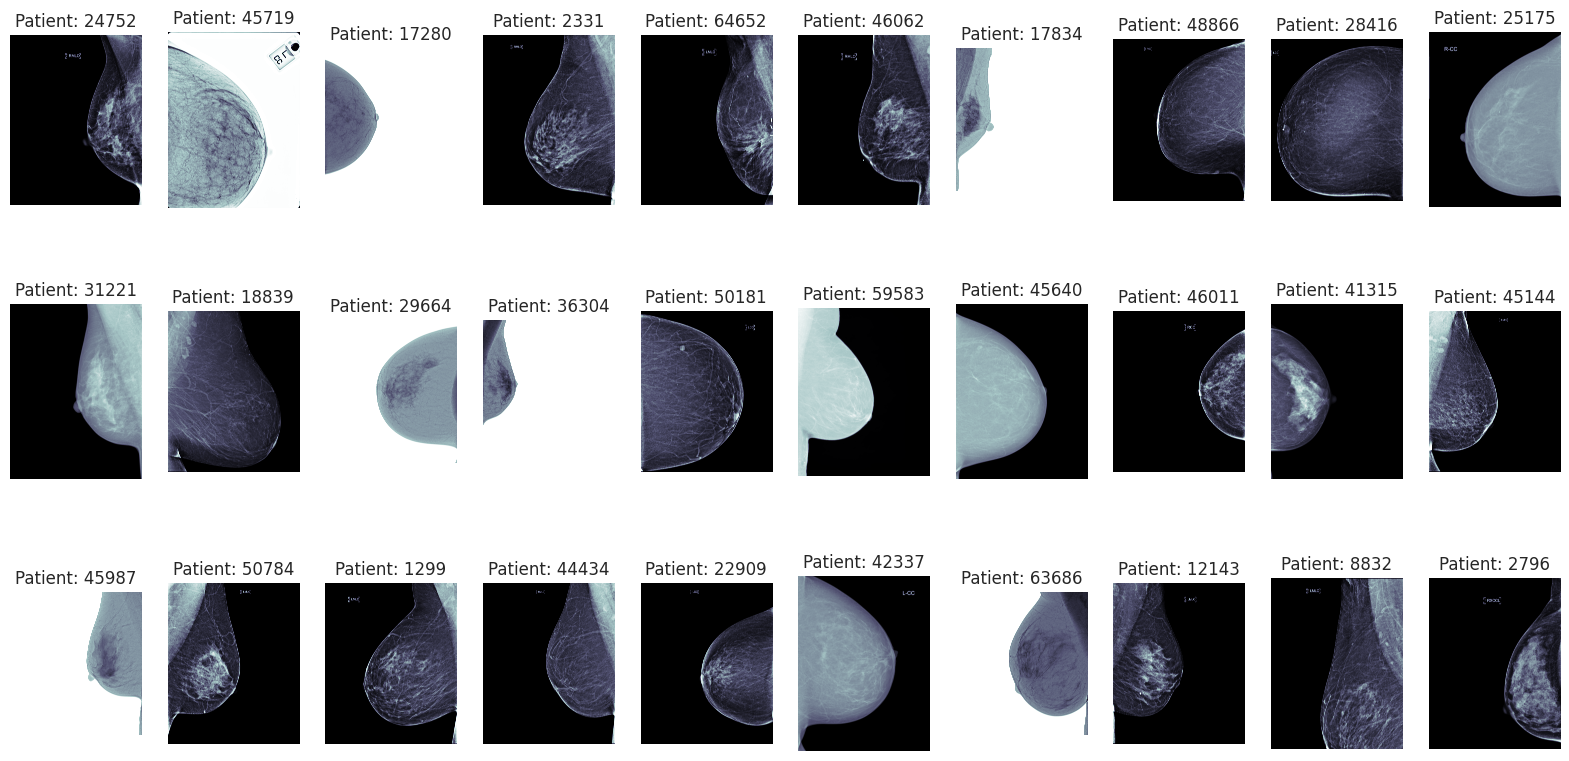

In [53]:
plt.figure(figsize=(20, 10))

for i, image in enumerate(example_image_paths):
    if os.path.exists(image):
        image, _, _, _ = load_dicom_image(image)
        plt.subplot(3, 10, i + 1)
        plt.imshow(image, cmap='bone')
        plt.axis('off')
        plt.title('Patient: ' + str(train_metadata.iloc[rand_patients[i]]['patient_id']))
    else:
        print('Dicom file not found!')
        
plt.show()

In [11]:
# Statistical analysis of metadata
print("\nAge Distribution in Train Set:")
print(train_metadata['age'].describe())

# Checking for class imbalance
print("\nCancer Class Distribution:")
print(train_metadata['cancer'].value_counts(normalize=True))


Age Distribution in Train Set:
count    54669.000000
mean        58.543928
std         10.050884
min         26.000000
25%         51.000000
50%         59.000000
75%         66.000000
max         89.000000
Name: age, dtype: float64

Cancer Class Distribution:
cancer
0    0.978832
1    0.021168
Name: proportion, dtype: float64


In [19]:
def image_statistics(image_path):
    try:
        dicom_image, _, _, _ = load_dicom_image(image_path)
        image = Image.fromarray(np.uint8(dicom_image)) 
        stat = ImageStat.Stat(image)
        return {"mean": stat.mean, "rms": stat.rms, "variance": stat.var}
    except Exception as e:
        print(f"Error in image_statistics: {e}")
        return None

# Example usage
stats = image_statistics(example_image_paths[0])
print(stats)

{'mean': [57.93568442418025], 'rms': [99.24548013606938], 'variance': [6493.12179774074]}


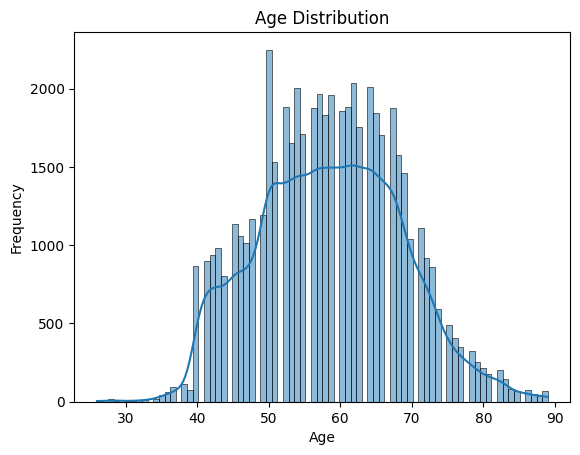

In [44]:
# Example: Plotting distribution of age
sns.histplot(train_metadata['age'], kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Example: Correlation heatmap
correlation_matrix = train_metadata.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Heatmap')
plt.show()

In [21]:
# Crosstab between 'biopsy' and 'cancer'
pd.crosstab(train_metadata['biopsy'], train_metadata['cancer'])

cancer,0,1
biopsy,,
0,51737,0
1,1811,1158


In [37]:
# Create a new column for contrast
train_metadata['contrast'] = None

# Iterate over the DataFrame and apply texture analysis
for index, row in train_metadata.iterrows():
    image_path = f"{data_path}/train_images/{row['patient_id']}/{row['image_id']}.dcm"
    contrast = texture_analysis(image_path)
    train_metadata.at[index, 'contrast'] = contrast


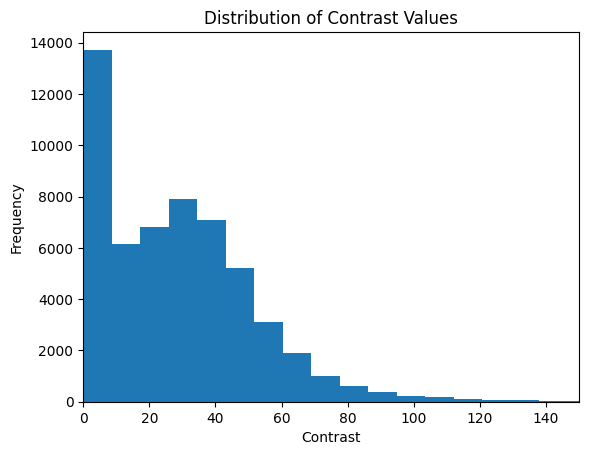

In [43]:
plt.hist(train_metadata['contrast'], bins=500)
plt.title('Distribution of Contrast Values')
plt.xlim(0, 150)
plt.xlabel('Contrast')
plt.ylabel('Frequency')
plt.show()

<Axes: xlabel='site_id', ylabel='age'>

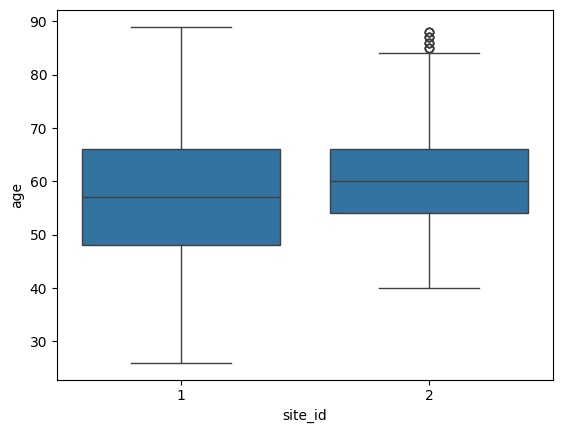

In [24]:
# Boxplot for a feature across different sites
sns.boxplot(x='site_id', y='age', data=train_metadata)

In [25]:
missing_data = train_metadata.isnull().sum()
print(missing_data)

site_id                        0
patient_id                     0
image_id                       0
laterality                     0
view                           0
age                           37
cancer                         0
biopsy                         0
invasive                       0
BIRADS                     28420
implant                        0
density                    25236
machine_id                     0
difficult_negative_case        0
dtype: int64


<Axes: >

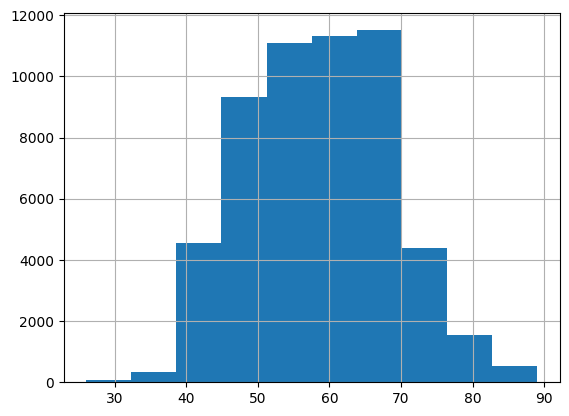

In [31]:
# Age distribution
train_metadata['age'].hist()

In [36]:
def texture_analysis(image_path):
    try:
        image, _, _, _ = load_dicom_image(image_path)
        # Ensure image is in the right format (2D and uint8)
        if image.ndim == 3:
            image = image[:, :, 0]  # Assuming grayscale, take the first channel
        image = (image / np.max(image) * 255).astype('uint8')  # Normalize and convert to uint8
        glcm = graycomatrix(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        return contrast
    except Exception as e:
        print(f"Error in texture_analysis: {e}")
        return None

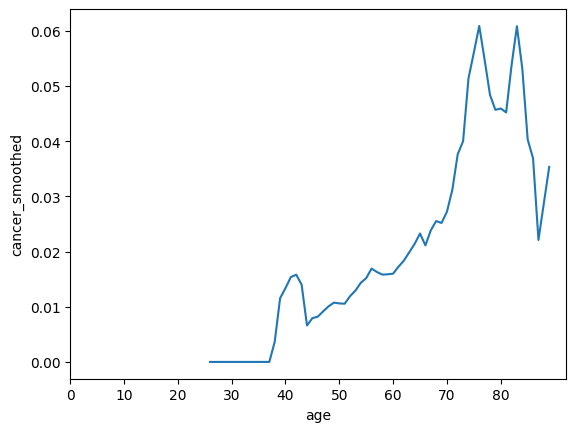

In [35]:
# Age vs. cancer rate, with age labels on x-axis only every 10 years
# Determine cancer rate for each age
age_cancer_rate = train_metadata.groupby('age')['cancer'].mean().reset_index()

# Interpolating missing ages (assuming age is a continuous variable)
age_cancer_rate['cancer_smoothed'] = age_cancer_rate['cancer'].rolling(window=5, min_periods=1).mean()

# Plot with smoothing
sns.lineplot(x='age', y='cancer_smoothed', data=age_cancer_rate)
plt.xticks(np.arange(0, 90, 10))
plt.show()


In [15]:
import cv2
# Crop image to breast region using bounding box and Otsu thresholding
def crop_coords(img):
    """
    Crop ROI from image.
    """
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    _, breast_mask = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    cnts, _ = cv2.findContours(breast_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key = cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    return x, y, w, h


def truncation_normalization(img):
    """
    Clip and normalize pixels in the breast ROI.
    @img : numpy array image
    return: numpy array of the normalized image
    """
    Pmin = np.percentile(img[img!=0], 5)
    Pmax = np.percentile(img[img!=0], 99)
    truncated = np.clip(img,Pmin, Pmax)  
    normalized = (truncated - Pmin)/(Pmax - Pmin)
    normalized[img==0]=0
    return normalized


def clahe(img, clip):
    """
    Image enhancement.
    @img : numpy array image
    @clip : float, clip limit for CLAHE algorithm
    return: numpy array of the enhanced image
    """
    clahe = cv2.createCLAHE(clipLimit=clip)
    cl = clahe.apply(np.array(img*255, dtype=np.uint8))
    return cl

In [7]:
roi_datapath = '/data/datasets/roi-dataset/rsna_annotations/yolo_ds/'

In [9]:
model = YOLO('yolov8n.pt')
roi_data = roi_datapath + 'data.yaml'
results = model.train(data=roi_data, epochs=25)

Ultralytics YOLOv8.0.215 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 48647MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/data/datasets/roi-dataset/rsna_annotations/yolo_ds/data.yaml, epochs=25, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_mask

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /data/datasets/roi-dataset/rsna_annotations/yolo_ds/train/labels.cache... 425 images, 0 backgrounds, 0 corrupt: 100%|██████████| 425/425 [00:00<?, ?it/s]
val: Scanning /data/datasets/roi-dataset/rsna_annotations/yolo_ds/valid/labels.cache... 47 images, 0 backgrounds, 0 corrupt: 100%|██████████| 47/47 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train5
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25       2.5G     0.9551      1.928      1.438         22        640: 100%|██████████| 27/27 [00:01<00:00, 13.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.36it/s]

                   all         47         47      0.989      0.787      0.977       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      2.36G      0.749      1.158      1.248         22        640: 100%|██████████| 27/27 [00:01<00:00, 19.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.31it/s]

                   all         47         47      0.951       0.83      0.931      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      2.36G     0.7655     0.9734      1.258         17        640: 100%|██████████| 27/27 [00:01<00:00, 21.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.40it/s]


                   all         47         47       0.77      0.851      0.926      0.777

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      2.36G     0.7811     0.9063      1.246         22        640: 100%|██████████| 27/27 [00:01<00:00, 22.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.22it/s]

                   all         47         47      0.993          1      0.995       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      2.36G     0.7916     0.8769      1.263         17        640: 100%|██████████| 27/27 [00:01<00:00, 23.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.31it/s]

                   all         47         47      0.498      0.957      0.575      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      2.36G     0.8141     0.8543       1.26         17        640: 100%|██████████| 27/27 [00:01<00:00, 20.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.01it/s]

                   all         47         47      0.822      0.872      0.895      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      2.35G     0.7083     0.6991      1.215         20        640: 100%|██████████| 27/27 [00:01<00:00, 23.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.25it/s]

                   all         47         47      0.977      0.906      0.971      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      2.36G     0.7028     0.6681      1.216         18        640: 100%|██████████| 27/27 [00:01<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.47it/s]

                   all         47         47      0.545      0.809      0.696       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      2.36G     0.6673     0.6158      1.182         19        640: 100%|██████████| 27/27 [00:01<00:00, 22.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.33it/s]

                   all         47         47      0.805      0.915      0.907       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      2.36G     0.6712     0.5919      1.161         27        640: 100%|██████████| 27/27 [00:01<00:00, 22.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.50it/s]

                   all         47         47      0.998          1      0.995      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      2.35G     0.6408     0.5666      1.159         24        640: 100%|██████████| 27/27 [00:01<00:00, 21.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.36it/s]

                   all         47         47      0.998          1      0.995      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      2.36G      0.657     0.5658      1.158         20        640: 100%|██████████| 27/27 [00:01<00:00, 22.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.89it/s]

                   all         47         47      0.998          1      0.995       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      2.36G     0.5844     0.5037      1.128         19        640: 100%|██████████| 27/27 [00:01<00:00, 22.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.21it/s]

                   all         47         47      0.999          1      0.995      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      2.36G      0.603      0.506      1.129         21        640: 100%|██████████| 27/27 [00:01<00:00, 21.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.39it/s]

                   all         47         47      0.866      0.962      0.982      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      2.35G     0.6118     0.5013      1.143         19        640: 100%|██████████| 27/27 [00:01<00:00, 19.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.51it/s]

                   all         47         47      0.994          1      0.995      0.911


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25       2.5G     0.4786     0.4574      1.112          9        640: 100%|██████████| 27/27 [00:01<00:00, 16.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.02it/s]

                   all         47         47      0.999          1      0.995      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      2.36G     0.4618      0.407      1.115          9        640: 100%|██████████| 27/27 [00:01<00:00, 21.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.23it/s]

                   all         47         47      0.999          1      0.995      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      2.36G     0.4489     0.3797      1.084          9        640: 100%|██████████| 27/27 [00:01<00:00, 21.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.24it/s]

                   all         47         47      0.999          1      0.995       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      2.35G     0.4574     0.3754      1.096          9        640: 100%|██████████| 27/27 [00:01<00:00, 21.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.83it/s]

                   all         47         47      0.998          1      0.995      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      2.36G     0.4196     0.3501      1.095          9        640: 100%|██████████| 27/27 [00:01<00:00, 21.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.45it/s]

                   all         47         47      0.999          1      0.995      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      2.36G     0.4073     0.3387       1.04          9        640: 100%|██████████| 27/27 [00:01<00:00, 22.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.88it/s]

                   all         47         47      0.999          1      0.995      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      2.36G     0.4094     0.3248      1.074          9        640: 100%|██████████| 27/27 [00:01<00:00, 21.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.41it/s]

                   all         47         47      0.999          1      0.995      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      2.35G     0.3715     0.3033      1.033          9        640: 100%|██████████| 27/27 [00:01<00:00, 21.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.39it/s]

                   all         47         47      0.999          1      0.995      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      2.36G     0.3455     0.2894      1.009          9        640: 100%|██████████| 27/27 [00:01<00:00, 20.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.55it/s]

                   all         47         47      0.999          1      0.995      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      2.36G     0.3605      0.288      1.026          9        640: 100%|██████████| 27/27 [00:01<00:00, 21.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.45it/s]

                   all         47         47      0.999          1      0.995       0.95



25 epochs completed in 0.014 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 6.2MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics YOLOv8.0.215 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 48647MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.60it/s]


                   all         47         47      0.999          1      0.995      0.951
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/train5


lr/pg0,▃▅▇███▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁
lr/pg1,▃▅▇███▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁
lr/pg2,▃▅▇███▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁
metrics/mAP50(B),█▇▇█▁▆█▃▇████████████████
metrics/mAP50-95(B),▅▅▆▇▁▅▅▃▆▇▇▇▇▇▇██▇███████
metrics/precision(B),█▇▅█▁▆█▂▅████▆███████████
metrics/recall(B),▁▂▃█▇▄▅▂▅████▇███████████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▆▆▆▆▆▅▅▅▅▄▅▄▄▄▃▂▂▂▂▂▂▁▁▁


In [190]:
# load model
yolo_model = YOLO('runs/detect/train5/weights/best.pt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
yolo_model.to(device)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [177]:
def invert_image_if_white_background(image_to_invert):
    """
    Invert the image.

    :param image_to_invert: A DICOM image as a NumPy array.
    :return: Inverted image.
    """      
    return image_to_invert.max() - image_to_invert

In [178]:
def resize_and_pad_image_isotropically(image, target_size):
    """
    Resize image to the target size, conserving aspect ratio and adding padding if needed.
    :param image: an image to resize
    :param target_size: target size of the image (width, height)
    :return: resized and padded image
    """
    h, w = image.shape[:2]
    # check for zero sized images
    if h == 0 or w == 0:
        print(f"Can't resize image with size 0: {image.shape}")
        raise ValueError(f"Can't resize image with size 0: {image.shape}")
    sh, sw = target_size

    # Interpolation method
    interp = cv2.INTER_AREA if h > sh or w > sw else cv2.INTER_CUBIC

    # Aspect ratio of image
    aspect = w / h

    # Compute new dimensions and scaling factor
    scale_w = sw / w
    scale_h = sh / h
    scale = min(scale_w, scale_h)
    new_w = int(w * scale)
    new_h = int(h * scale)

    # Calculate padding
    pad_left = (sw - new_w) // 2
    pad_right = sw - new_w - pad_left
    pad_top = (sh - new_h) // 2
    pad_bot = sh - new_h - pad_top

    # Resize the image
    resized_img = cv2.resize(image, (new_w, new_h), interpolation=interp)

    # Add padding
    resized_img = cv2.copyMakeBorder(resized_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return resized_img

In [179]:
def convert_image_float32_and_normalize(original_image):
    """
    Convert the image to float32 and normalize to [0, 1].
    :param original_image: The image as a NumPy array.
    :return: A normalized image as a NumPy array.
    """
    resized_image = original_image.astype(np.float32) / np.max(original_image)  # Normalize to [0, 1]
    return resized_image

In [180]:
transform_to_tensor = transforms.Compose([
    transforms.ToTensor(),  # Convert numpy array to PyTorch Tensor
    # Add any other necessary transformations here
])

In [181]:
def load_and_preprocess_images(image_paths):
    """
    Load DICOM images and apply initial preprocessing.
    """
    images = []
    window_centers = []
    window_widths = []
    inverts = []
    for img_path in image_paths:
        try:
            img, window_center, window_width, invert = load_dicom_image(img_path)
            images.append(img)
            window_centers.append(window_center)
            window_widths.append(window_width)
            inverts.append(invert)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            images.append(None)
            window_centers.append(None)
            window_widths.append(None)
            inverts.append(None)
            
    return images, window_centers, window_widths, inverts


def resize_image_for_yolo(image, target_size=(640, 640)):
    """
    Resize image maintaining aspect ratio and padding for YOLO model.
    """
    # Resize and pad the image as required by YOLO
    resized_img = resize_and_pad_image_isotropically(image, target_size)
    return resized_img

In [182]:
def preprocess_for_yolo(images, inverts):
    """
    Preprocess images for YOLO model input.
    """
    processed_images = []
    for img, invert in zip(images, inverts):
        if img is not None:
            try:
                # Invert image if it has a white background
                img = invert_image_if_white_background(img) if invert else img
                # Resize image to the input size expected by YOLO (e.g., 640x640)
                resized_img = resize_image_for_yolo(img, (640, 640))

                # Convert image to float32 and normalize
                normalized_img = convert_image_float32_and_normalize(resized_img)

                # Convert image to PyTorch tensor and add batch dimension
                tensor_img = transform_to_tensor(normalized_img).unsqueeze(0)

                processed_images.append(tensor_img)
            except Exception as e:
                print(f"Error preprocessing for YOLO: {e}")
                processed_images.append(None)
        else:
            processed_images.append(None)

    # Concatenate all tensor images into a single batch
    batched_tensor = torch.cat([img for img in processed_images if img is not None], dim=0)
    # Convert to rgb
    batched_tensor_rgb = batched_tensor.repeat(1, 3, 1, 1)
    return batched_tensor_rgb

In [191]:
def calculate_resized_dimensions(original_size, target_size=(640, 640)):
    """
    Calculate the resized dimensions of an image, for use in transforming bbox to original image size.
    :param original_size: The starting size of the image as a tuple (width, height).
    :param target_size: The target size of the image as a tuple (width, height).
    :return: 
    """
    original_width, original_height = original_size
    target_width, target_height = target_size

    # Calculate aspect ratio
    aspect_ratio = original_width / original_height

    # Determine resized dimensions before padding
    if aspect_ratio > 1:  # Landscape orientation
        resized_width = target_width
        resized_height = int(resized_width / aspect_ratio)
    else:  # Portrait orientation or square
        resized_height = target_height
        resized_width = int(resized_height * aspect_ratio)

    return resized_width, resized_height


def convert_bbox_to_original_with_padding(bbox, original_size, padded_size=(640, 640)):
    """
    Convert bounding box coordinates from a resized and padded image to the original image.

    :param bbox: Tuple (xmin, ymin, xmax, ymax) on the resized and padded image.
    :param original_size: Tuple (original_width, original_height) of the image.
    :param padded_size: Final size of the image after padding.
    :return: Adjusted bounding box coordinates as a tuple.
    """
    resized_width, resized_height = calculate_resized_dimensions(original_size, padded_size)
    scale_w = original_size[0] / resized_width
    scale_h = original_size[1] / resized_height

    # Determine padding added during resizing
    pad_w = (padded_size[0] - resized_width) / 2
    pad_h = (padded_size[1] - resized_height) / 2

    # Adjust bounding box coordinates
    xmin, ymin, xmax, ymax = bbox.flatten()
    xmin_original = max((xmin - pad_w) * scale_w, 0)  # Ensure non-negative
    ymin_original = max((ymin - pad_h) * scale_h, 0)  # Ensure non-negative
    xmax_original = min((xmax - pad_w) * scale_w, original_size[0])  # Ensure within original width
    ymax_original = min((ymax - pad_h) * scale_h, original_size[1])  # Ensure within original height

    return xmin_original, ymin_original, xmax_original, ymax_original


def crop_image(uncropped_image, bbox):
    """
    Crop an image to the bounding box coordinates.

    :param uncropped_image: The image as a NumPy array.
    :param bbox: Tuple (xmin, ymin, xmax, ymax) of the bounding box coordinates.
    :return: Cropped image as a NumPy array.
    """
    xmin, ymin, xmax, ymax = bbox
    # if crop would be empty, return original image
    if xmin == xmax or ymin == ymax:
        return uncropped_image
    else:
        return uncropped_image[int(ymin):int(ymax), int(xmin):int(xmax)]


def crop_images_with_yolo(raw_images, yolo_model, inverts):
    """
    Crop images using the YOLO model.
    """
    preprocessed_images = preprocess_for_yolo(raw_images, inverts)
    preprocessed_images.to(device)
    yolo_results = yolo_model(preprocessed_images, verbose=False)
    cropped_images = []
    for i, result in enumerate(yolo_results):
        if raw_images[i] is not None:
            try:
                bbox = convert_bbox_to_original_with_padding(result.boxes[0].xyxy.cpu().numpy(), (raw_images[i].shape[1], raw_images[i].shape[0]))
                cropped_img = crop_image(raw_images[i], bbox)
                cropped_images.append(cropped_img)
            except Exception as e:
                print(f"Error cropping image: {e}")
                cropped_images.append(None)
        else:
            cropped_images.append(None)
    return cropped_images


In [192]:
def apply_window_single(image_to_window, win_center, win_width):
    """
    Apply windowing to a grayscale image.

    :param image_to_window: The image as a NumPy array.
    :param win_center: The window center.
    :param win_width: The window width.
    :return: The windowed image as a NumPy array.
    """
    # Check that image is numpy array
    assert isinstance(image_to_window, np.ndarray)
    # Handle MultiValue objects
    if isinstance(win_width, pydicom.multival.MultiValue):
        # Choose the first value
        win_width = float(win_width[0])

    if isinstance(win_center, pydicom.multival.MultiValue):
        win_center = float(win_center[0])

    window_min = win_center - (win_width / 2)
    window_max = win_center + (win_width / 2)

    return np.clip(image_to_window, window_min, window_max)


def apply_windowing(images, window_centers_array, window_widths_array):
    """
    Apply windowing to a batch of images.
    """
    images_to_return = []
    for img, window_cnt, window_wid in zip(images, window_centers_array, window_widths_array):
        if img is not None:
            try:
                windowed_img = apply_window_single(img, window_cnt, window_wid)
                images_to_return.append(windowed_img)
            except Exception as e:
                print(f"Error applying windowing: {e}")
                images_to_return.append(None)
        else:
            images_to_return.append(None)
    return images_to_return


def convert_to_rgb_and_normalize(images):
    """
    Convert images to RGB and normalize.
    """
    final_images = []
    for img in images:
        if img is not None and np.max(img) > 0:
            try:
                normalized_img = (img - np.min(img)) / (np.max(img) - np.min(img))
                scaled_img = np.uint8(normalized_img * 255)
                # Convert to RGB and scale to [0, 255]
                rgb_img = np.stack((scaled_img, scaled_img, scaled_img), axis=-1)
                final_images.append(rgb_img)
            except Exception as e:
                print(f"Error converting/normalizing image: {e}")
                final_images.append(None)
        else:
            final_images.append(None)
    return final_images

In [193]:
def preprocess_dicom_images(image_paths, YOLO_model):
    """
    Preprocess DICOM images for training.
    """
    images, window_centers, window_widths, inverts = load_and_preprocess_images(image_paths)
    cropped_images = crop_images_with_yolo(images, YOLO_model, inverts)
    windowed_images = apply_windowing(cropped_images, window_centers, window_widths)
    rgb_images = convert_to_rgb_and_normalize(windowed_images)
    rgb_images = [invert_image_if_white_background(img) if invert else img for img, invert in zip(rgb_images, inverts)]
    final_images = [resize_and_pad_image_isotropically(img, target_size=(2048, 1024)) for img in rgb_images]
    
    return final_images

In [200]:
from tqdm import tqdm
def save_image(image, save_path):
    """
    Save a NumPy array as an image.
    :param image: The image as a NumPy array.
    :param save_path: The path to save the image.
    :return: None
    """
    # Convert to PIL Image
    image = Image.fromarray(image)
    # Save to disk
    image.save(save_path)

def batch_preprocess_and_save(metadata_df, batch_size, YOLO_model, save_dir):
    """
    Preprocess DICOM images for training and save them to disk.
    :param image_paths: Image paths to preprocess.
    :param batch_size: Batch size.
    :param YOLO_model: Pretrained YOLO model.
    :param save_dir: Path to save the preprocessed images.
    :return: Modified metadata DataFrame.
    """
    image_paths = metadata_df['image_path'].values
    num_batches = len(image_paths) // batch_size + int(len(image_paths) % batch_size != 0)
    temp_metadata_df = metadata_df.copy()
    temp_metadata_df['preprocessed_image_path'] = pd.NA
    
    for i in tqdm(range(num_batches), desc='Preprocessing images'):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        batch_paths = image_paths[start_idx:end_idx]
        
        temp_df = pd.DataFrame(index=range(start_idx, end_idx), columns=temp_metadata_df.columns)
        
        try:
            batch_images = preprocess_dicom_images(batch_paths, YOLO_model)
        
            for j, img in enumerate(batch_images):
                patient_id = row.patient_id
                image_id = row.image_id
                save_path = os.path.join(save_dir, f"{patient_id}_{image_id}_preprocessed.png")
                temp_df.at[start_idx + j, 'preprocessed_image_path'] = save_path
                save_image(img, save_path)
            
            temp_metadata_df.update(temp_df)
            
        except Exception as e:
            print(f"Error in batch_preprocess_and_save: {e}")
            continue

    return temp_metadata_df

In [201]:
train_metadata['image_path'] = data_path + 'train_images/' + train_metadata['patient_id'].astype(str) + '/' + train_metadata['image_id'].astype(str) + '.dcm'

In [196]:
save_dir = '/data/datasets/rsna-breast-cancer-detection/preprocessed_images_full_v2/'
updated_meta_df = batch_preprocess_and_save(train_metadata, 16, yolo_model, save_dir)

Preprocessing images:  26%|██▌       | 896/3420 [1:54:29<5:34:01,  7.94s/it]

Error cropping image: index 0 is out of bounds for dimension 0 with size 0


Preprocessing images:  26%|██▌       | 897/3420 [1:54:32<4:34:06,  6.52s/it]

Error in batch_preprocess_and_save: 'NoneType' object has no attribute 'shape'


Preprocessing images: 100%|██████████| 3420/3420 [7:16:41<00:00,  7.66s/it]  


In [152]:
updated_meta_df_cleaned = updated_meta_df.dropna(subset=['preprocessed_image_path'])
updated_meta_df_cleaned.to_csv(data_path + 'preprocessed_full_metadata.csv')

In [5]:
updated_meta_df_cleaned = pd.read_csv(data_path + 'preprocessed_full_metadata.csv')

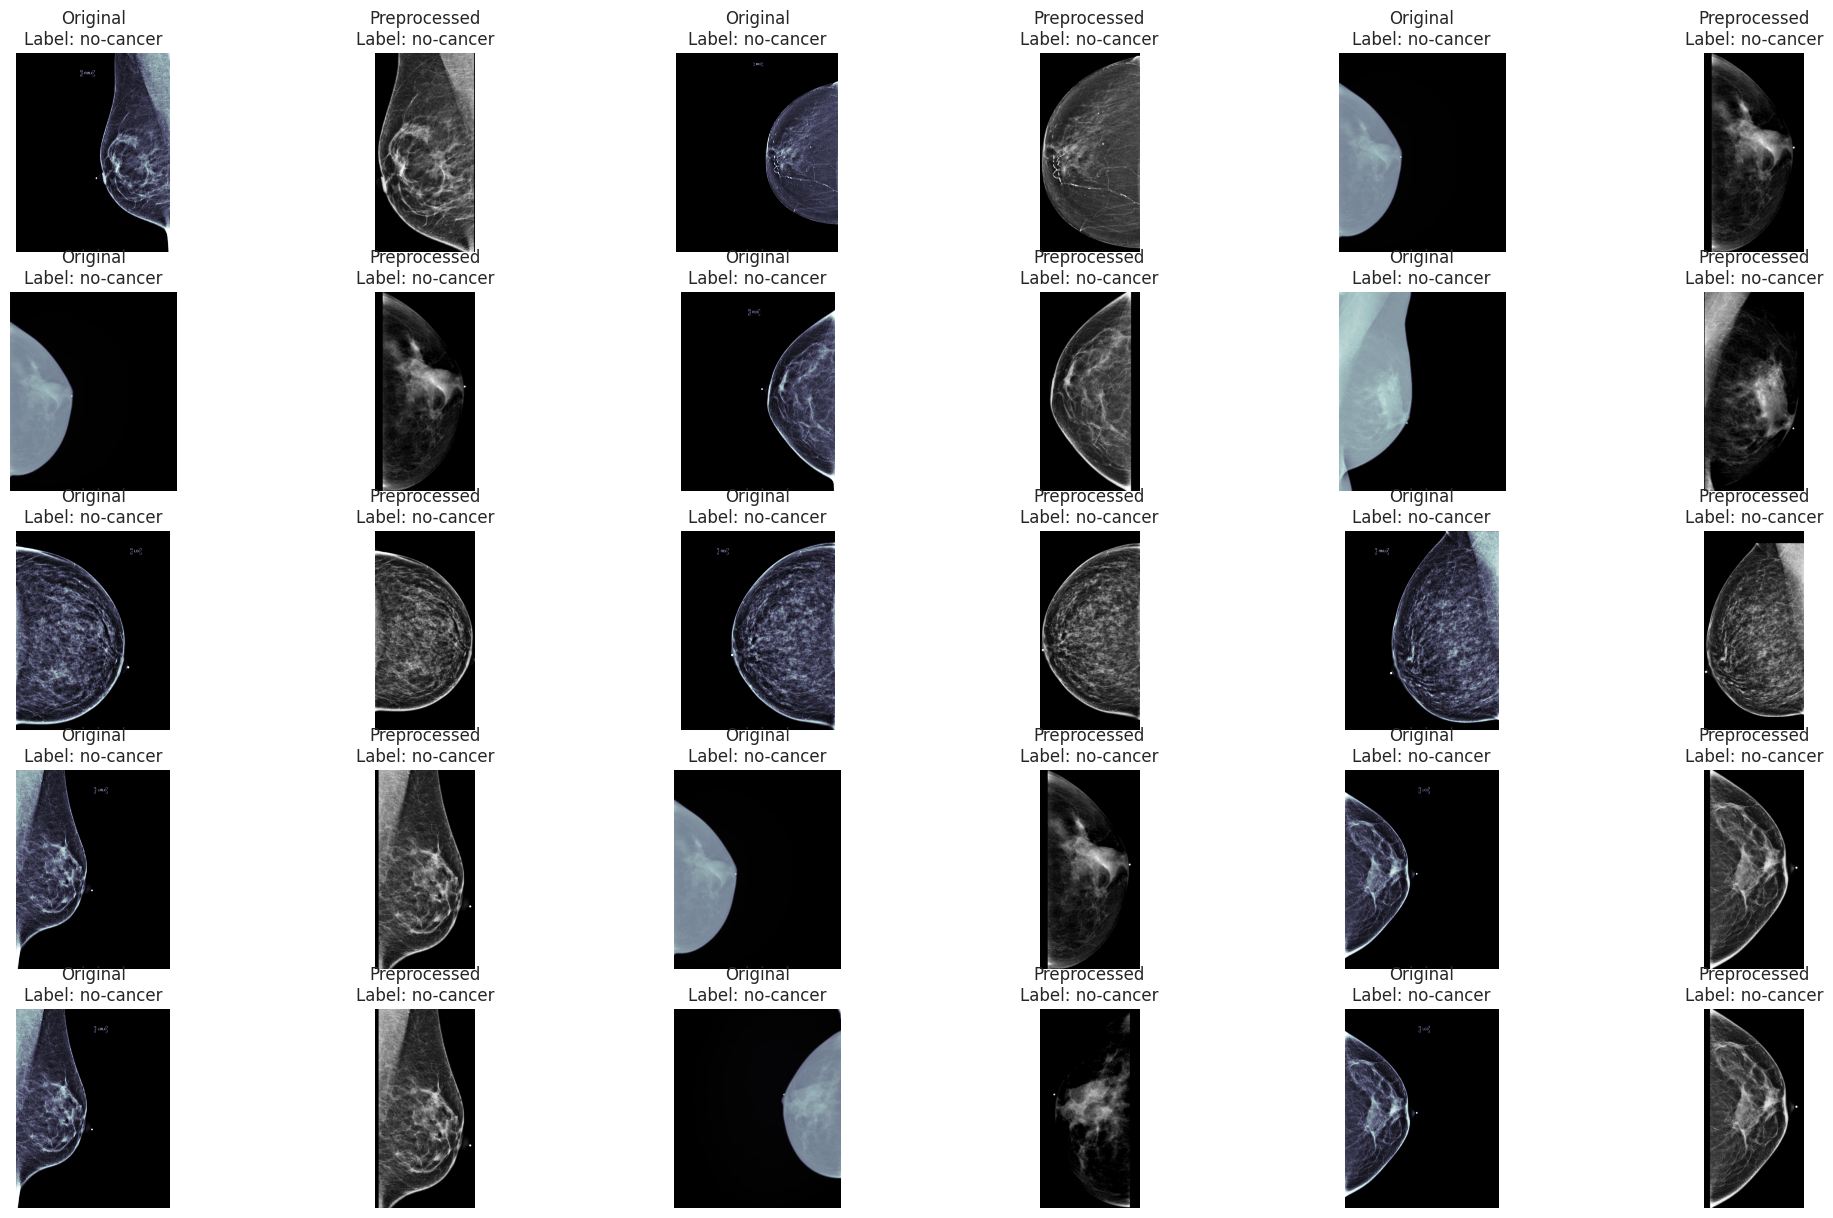

In [216]:
# Select 15 random patients (indices)
rand_indices = np.random.randint(54660, len(updated_meta_df_cleaned), 15)
labels = ['no-cancer', 'cancer']

plt.figure(figsize=(25, 15))

for i, idx in enumerate(rand_indices):
    # Get paths for unprocessed and preprocessed images
    unprocessed_image_path = updated_meta_df_cleaned.iloc[idx]['image_path']
    preprocessed_image_path = updated_meta_df_cleaned.iloc[idx]['preprocessed_image_path']
    
    # Plot unprocessed image
    if os.path.exists(unprocessed_image_path):
        image, _, _, _ = load_dicom_image(unprocessed_image_path)
        plt.subplot(5, 6, 2 * i + 1)  # 2*i+1 for unprocessed images
        plt.imshow(image, cmap='bone')
        plt.axis('off')
        plt.title('Original\nLabel: ' + labels[updated_meta_df_cleaned.iloc[idx]['cancer']])
    else:
        print('Unprocessed image not found!')

    # Plot preprocessed image
    if os.path.exists(preprocessed_image_path):
        image = Image.open(preprocessed_image_path)
        plt.subplot(5, 6, 2 * i + 2)  # 2*i+2 for preprocessed images
        plt.imshow(image, cmap='bone')
        plt.axis('off')
        plt.title('Preprocessed\nLabel: ' + labels[updated_meta_df_cleaned.iloc[idx]['cancer']])
    else:
        print('Preprocessed image not found!')

plt.show()

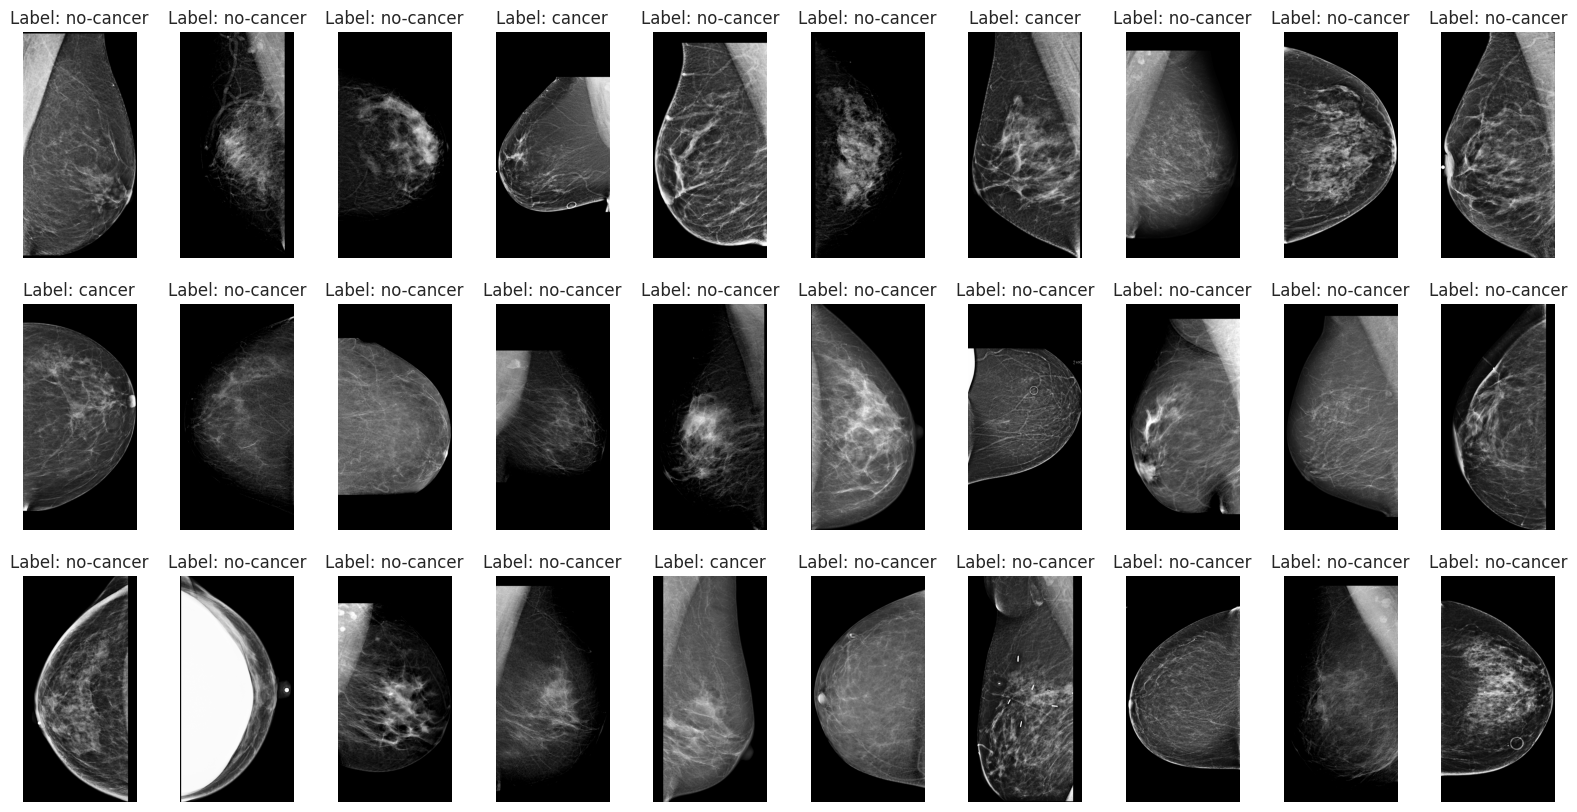

In [217]:
# Plot a few random preprocessed images
rand_patients = np.random.randint(0, len(updated_meta_df_cleaned), 30)
example_image_paths = [updated_meta_df_cleaned.iloc[rand_patient]['preprocessed_image_path'] for rand_patient in rand_patients]

plt.figure(figsize=(20, 10))
labels = ['no-cancer', 'cancer']
for i, image in enumerate(example_image_paths):
    if os.path.exists(image):
        image = Image.open(image)
        plt.subplot(3, 10, i + 1)
        plt.imshow(image, cmap='bone')
        plt.axis('off')
        plt.title('Label: ' + labels[updated_meta_df_cleaned.iloc[rand_patients[i]]['cancer']])
    else:
        print('Image not found!')
        
plt.show()

In [7]:
# Data augmentation

In [6]:
from albumentations import random_utils
from albumentations.augmentations.crops import functional as F
from albumentations.augmentations.geometric import functional as FGeometric
from albumentations.augmentations.utils import (_maybe_process_in_chunks,
                                                preserve_shape)
from albumentations.core.transforms_interface import (DualTransform,
                                                      ImageOnlyTransform)
import math
import random

class _CustomBaseRandomSizedCropNoResize(DualTransform):
    # Base class for RandomSizedCrop and RandomResizedCrop

    def __init__(self, always_apply=False, p=1.0):
        super(_CustomBaseRandomSizedCropNoResize,
              self).__init__(always_apply, p)

    def apply(self,
              img,
              crop_height=0,
              crop_width=0,
              h_start=0,
              w_start=0,
              interpolation=cv2.INTER_LINEAR,
              **params):
        return F.random_crop(img, crop_height, crop_width, h_start, w_start)

    def apply_to_bbox(self,
                      bbox,
                      crop_height=0,
                      crop_width=0,
                      h_start=0,
                      w_start=0,
                      rows=0,
                      cols=0,
                      **params):
        return F.bbox_random_crop(bbox, crop_height, crop_width, h_start,
                                  w_start, rows, cols)

    def apply_to_keypoint(self,
                          keypoint,
                          crop_height=0,
                          crop_width=0,
                          h_start=0,
                          w_start=0,
                          rows=0,
                          cols=0,
                          **params):
        keypoint = F.keypoint_random_crop(keypoint, crop_height, crop_width,
                                          h_start, w_start, rows, cols)
        scale_x = self.width / crop_width
        scale_y = self.height / crop_height
        keypoint = FGeometric.keypoint_scale(keypoint, scale_x, scale_y)
        return keypoint
    
class CustomRandomSizedCropNoResize(_CustomBaseRandomSizedCropNoResize):
    """Torchvision's variant of crop a random part of the input and rescale it to some size.

    Args:
        scale ((float, float)): range of size of the origin size cropped
        ratio ((float, float)): range of aspect ratio of the origin aspect ratio cropped
        interpolation (OpenCV flag): flag that is used to specify the interpolation algorithm. Should be one of:
            cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_CUBIC, cv2.INTER_AREA, cv2.INTER_LANCZOS4.
            Default: cv2.INTER_LINEAR.
        p (float): probability of applying the transform. Default: 1.

    Targets:
        image, mask, bboxes, keypoints

    Image types:
        uint8, float32
    """

    def __init__(
            self,
            scale=(0.08, 1.0),
            ratio=(0.75, 1.3333333333333333),
            always_apply=False,
            p=1.0,
    ):

        super(CustomRandomSizedCropNoResize,
              self).__init__(always_apply=always_apply, p=p)
        self.scale = scale
        self.ratio = ratio

    def get_params_dependent_on_targets(self, params):
        img = params["image"]
        area = img.shape[0] * img.shape[1]

        for _attempt in range(10):
            target_area = random.uniform(*self.scale) * area
            log_ratio = (math.log(self.ratio[0]), math.log(self.ratio[1]))
            aspect_ratio = math.exp(random.uniform(*log_ratio))

            w = int(round(math.sqrt(target_area *
                                    aspect_ratio)))  # skipcq: PTC-W0028
            h = int(round(math.sqrt(target_area /
                                    aspect_ratio)))  # skipcq: PTC-W0028

            if 0 < w <= img.shape[1] and 0 < h <= img.shape[0]:
                i = random.randint(0, img.shape[0] - h)
                j = random.randint(0, img.shape[1] - w)
                return {
                    "crop_height": h,
                    "crop_width": w,
                    "h_start": i * 1.0 / (img.shape[0] - h + 1e-10),
                    "w_start": j * 1.0 / (img.shape[1] - w + 1e-10),
                }

        # Fallback to central crop
        in_ratio = img.shape[1] / img.shape[0]
        if in_ratio < min(self.ratio):
            w = img.shape[1]
            h = int(round(w / min(self.ratio)))
        elif in_ratio > max(self.ratio):
            h = img.shape[0]
            w = int(round(h * max(self.ratio)))
        else:  # whole image
            w = img.shape[1]
            h = img.shape[0]
        i = (img.shape[0] - h) // 2
        j = (img.shape[1] - w) // 2
        return {
            "crop_height": h,
            "crop_width": w,
            "h_start": i * 1.0 / (img.shape[0] - h + 1e-10),
            "w_start": j * 1.0 / (img.shape[1] - w + 1e-10),
        }

    def get_params(self):
        return {}

    @property
    def targets_as_params(self):
        return ["image"]

    def get_transform_init_args_names(self):
        return "scale", "ratio"


In [7]:
class TrainAugment:

    def __init__(self):
        self.transform_fn = A.Compose(
            [
                # crop
                CustomRandomSizedCropNoResize(scale=(0.5, 1.0),
                                              ratio=(0.5, 0.8),
                                              always_apply=False,
                                              p=0.4),

                # flip
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),

                # downscale
                A.OneOf([
                    A.Downscale(scale_min=0.75,
                                scale_max=0.95,
                                interpolation=dict(upscale=cv2.INTER_LINEAR,
                                                   downscale=cv2.INTER_AREA),
                                always_apply=False,
                                p=0.1),
                    A.Downscale(scale_min=0.75,
                                scale_max=0.95,
                                interpolation=dict(upscale=cv2.INTER_LANCZOS4,
                                                   downscale=cv2.INTER_AREA),
                                always_apply=False,
                                p=0.1),
                    A.Downscale(scale_min=0.75,
                                scale_max=0.95,
                                interpolation=dict(upscale=cv2.INTER_LINEAR,
                                                   downscale=cv2.INTER_LINEAR),
                                always_apply=False,
                                p=0.8),
                ],
                        p=0.125),

                # contrast
                # relative dark/bright between region, like HDR
                A.OneOf([
                    A.RandomToneCurve(scale=0.3, always_apply=False, p=0.5),
                    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.2),
                                               contrast_limit=(-0.4, 0.5),
                                               brightness_by_max=True,
                                               always_apply=False,
                                               p=0.5)
                ],
                        p=0.5),

                # affine
                A.OneOf(
                    [
                        A.ShiftScaleRotate(shift_limit=None,
                                           scale_limit=[-0.15, 0.15],
                                           rotate_limit=[-30, 30],
                                           interpolation=cv2.INTER_LINEAR,
                                           border_mode=cv2.BORDER_CONSTANT,
                                           value=0,
                                           mask_value=None,
                                           shift_limit_x=[-0.1, 0.1],
                                           shift_limit_y=[-0.2, 0.2],
                                           rotate_method='largest_box',
                                           always_apply=False,
                                           p=0.6),

                        # one of with other affine
                        A.ElasticTransform(alpha=1,
                                           sigma=20,
                                           alpha_affine=10,
                                           interpolation=cv2.INTER_LINEAR,
                                           border_mode=cv2.BORDER_CONSTANT,
                                           value=0,
                                           mask_value=None,
                                           approximate=False,
                                           same_dxdy=False,
                                           always_apply=False,
                                           p=0.2),

                        # distort
                        A.GridDistortion(num_steps=5,
                                         distort_limit=0.3,
                                         interpolation=cv2.INTER_LINEAR,
                                         border_mode=cv2.BORDER_CONSTANT,
                                         value=0,
                                         mask_value=None,
                                         normalized=True,
                                         always_apply=False,
                                         p=0.2),
                    ],
                    p=0.5),

                # random erase
                A.CoarseDropout(max_holes=6,
                                max_height=0.15,
                                max_width=0.25,
                                min_holes=1,
                                min_height=0.05,
                                min_width=0.1,
                                fill_value=0,
                                mask_fill_value=None,
                                always_apply=False,
                                p=0.25),
            ],
            p=0.9)

        print('TRAIN AUG:\n', self.transform_fn)

    def __call__(self, img):
        return self.transform_fn(image=img)['image']

In [8]:
from albumentations.pytorch import ToTensorV2

class Transform:
    def __init__(self, input_size, mean=(0.485, 0.456, 0.406), std=(0.228, 0.224, 0.225), interpolation=cv2.INTER_LINEAR):
        self.input_size = input_size
        self.interpolation = interpolation
        self.max_h, self.max_w = input_size
        self.mean = mean
        self.std = std

        def _fit_resize(image, **kwargs):
            img_h, img_w = image.shape[:2]
            r = min(self.max_h / img_h, self.max_w / img_w)
            new_h, new_w = int(img_h * r), int(img_w * r)
            new_image = cv2.resize(image, (new_w, new_h),
                                   interpolation=interpolation)
            return new_image
        
        def _ensure_three_channels(image, **kwargs):
            if len(image.shape) == 2 or image.shape[2] == 1:
                print(f"Image shape: {image.shape}")
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            return image

        self.transform_fn = A.Compose([
            A.Lambda(name="FitResize",
                     image=_fit_resize,
                     always_apply=True,
                     p=1.0),
            A.Lambda(name="Ensure3Channels", image=_ensure_three_channels, always_apply=True, p=1.0),
            A.PadIfNeeded(min_height=self.max_h,
                          min_width=self.max_w,
                          pad_height_divisor=None,
                          pad_width_divisor=None,
                          position=A.augmentations.geometric.transforms.
                          PadIfNeeded.PositionType.CENTER,
                          border_mode=cv2.BORDER_CONSTANT,
                          value=0,
                          mask_value=None,
                          always_apply=True,
                          p=1.0),
            ToTensorV2(transpose_mask=True),
        ])

    def __call__(self, img):
        return self.transform_fn(image=img)['image']

In [9]:
# Create a Dataset object, with the image paths, plus the target from the new metadata df
class ImageDataset(Dataset):
    def __init__(self, metadata_df, augmentations=None, transform=None):
        self.image_paths = metadata_df['preprocessed_image_path'].values
        self.targets = metadata_df['cancer'].values
        self.augmentations = augmentations
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def get_labels(self):
        return self.targets
    
    def __getitem__(self, idx):
        # load the image
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        image = np.array(image)
        
        # Apply augmentations
        if self.augmentations:
            image = self.augmentations(image)
            
        # apply the transform
        if self.transform:
            image = self.transform(image)
            
        # get the target
        target = self.targets[idx]

        return image, target

In [124]:
image_sample = Image.open(updated_meta_df_cleaned.iloc[0]['preprocessed_image_path']).convert('RGB')
image_sample = np.array(image_sample)

In [140]:
img_h, img_w = image_sample.shape[:2]
print(f'Image shape: {image_sample.shape[:2]}')

Image shape: (2048, 1024)


In [141]:
# get some info about the sample
print(f'Image shape: {image_sample.shape}')
print(f'Image dtype: {image_sample.dtype}')
print(f'Image min: {image_sample.min()}')
print(f'Image max: {image_sample.max()}')
print(f'Image mean: {image_sample.mean()}')
print(f'Image std: {image_sample.std()}')

Image shape: (2048, 1024, 3)
Image dtype: uint8
Image min: 0
Image max: 239
Image mean: 25.153303623199463
Image std: 39.29154924122754


In [142]:
img_h, img_w = image_sample.shape[:2]
r = min(2048 / img_h, 1024 / img_w)
new_h, new_w = int(img_h * r), int(img_w * r)
new_image = cv2.resize(image_sample, (new_w, new_h),
                       interpolation=cv2.INTER_LINEAR)
# info about the resized image
print(f'Image shape: {new_image.shape}')
print(f'Image dtype: {new_image.dtype}')
print(f'Image min: {new_image.min()}')
print(f'Image max: {new_image.max()}')
print(f'Image mean: {new_image.mean()}')
print(f'Image std: {new_image.std()}')

Image shape: (2048, 1024, 3)
Image dtype: uint8
Image min: 0
Image max: 239
Image mean: 25.153303623199463
Image std: 39.29154924122754


In [10]:
import math
import torch
import numpy as np
from torch.utils.data import Sampler
import torch.distributed as dist

class BalanceSampler(Sampler):
    def __init__(self, dataset, batch_size, num_sched_epochs, num_epochs, start_ratio = 1/4, end_ratio = 1/8, one_pos_mode = True, seed = 42):
        np.random.seed(seed)
        self.dataset = dataset
        self.batch_size = batch_size
        self.start_ratio = start_ratio
        self.end_ratio = end_ratio
        self.num_sched_epochs = num_sched_epochs
        self.num_epochs = num_epochs
        labels = dataset.get_labels()
        
        self.pos_idxs = np.where(labels>0)[0]
        self.neg_idxs = np.where(labels==0)[0]
        self.num_pos = len(self.pos_idxs)
        self.num_neg = len(self.neg_idxs)
        print(f'Num pos: {self.num_pos}, Num neg: {self.num_neg}')

        # percentage of pos samples per epoch
        if start_ratio != end_ratio:
            self.ratios = np.linspace(start_ratio, end_ratio, num_sched_epochs)
            self.ratios = np.concatenate([self.ratios, np.full((num_epochs - num_sched_epochs,), end_ratio)])
        else:
            self.ratios = np.full((num_epochs,), start_ratio)
        print('RATIO PER EPOCHS:', self.ratios)
        assert len(self.ratios) == num_epochs

        # pre-compute sampler indexs per epoch
        self.pre_compute_epoch_idxs = []
        for i, ratio in enumerate(self.ratios):
            epoch_idxs = self._pre_compute_epoch_idxs(ratio, one_pos_mode= one_pos_mode)
            self.pre_compute_epoch_idxs.append(epoch_idxs)
        self.cur_epoch = None

        self.set_epoch(0)


    def set_epoch(self, ep):
        assert ep < self.num_epochs, f'WARNING: Invalid set_epoch() with ep={ep} while max_epoch={self.num_epochs}'
        print(f'Set epoch to {ep} with sampler ratio = {self.ratios[ep]}')
        self.cur_epoch = ep
        self.len = len(self.pre_compute_epoch_idxs[ep])

    def _pre_compute_epoch_idxs(self, ratio, one_pos_mode = True):
        print(f'Pre-compute for ratio = {ratio}')
        epoch_num_pos = int(ratio * self.num_neg)
        epoch_num_iters = (epoch_num_pos + self.num_neg) // self.batch_size
        epoch_num_total = epoch_num_iters * self.batch_size
        # never downsampling neg samples if possible
        epoch_num_pos = epoch_num_total - self.num_neg
        
        # sampling pos idxs
        min_pos_per_iter = epoch_num_pos // epoch_num_iters
        if min_pos_per_iter < 1:
            if one_pos_mode:
                min_pos_per_iter = 1
                epoch_num_pos = epoch_num_iters
                print(f'ONE POS MODE: Switch num_pos_samples to {epoch_num_pos}')
            else:
                print(f"WARNING: At least one batch which has no positive sample: {epoch_num_pos}, {epoch_num_iters}.\n")
            
        ret_idxs = []
        pool_pos_idxs = []
        _count = 0
        while _count < epoch_num_pos:
            temp_pos_idxs = self.pos_idxs.copy()
            np.random.shuffle(temp_pos_idxs)
            pool_pos_idxs.append(temp_pos_idxs)
            _count += len(temp_pos_idxs)
        pool_pos_idxs = np.concatenate(pool_pos_idxs, axis = 0)
        assert len(pool_pos_idxs) >= epoch_num_pos

        _start = 0
        _end = 0
        for i in range(epoch_num_iters):
            _start = i * min_pos_per_iter
            _end = (i+1) * min_pos_per_iter
            ret_idxs.append(pool_pos_idxs[_start:_end].tolist())
        num_pos_remain = epoch_num_pos - _end
        assert num_pos_remain == epoch_num_pos % epoch_num_iters
        pool_remain_pos_idxs = pool_pos_idxs[_end:epoch_num_pos]
        assert len(pool_remain_pos_idxs) == num_pos_remain
        for i, j in enumerate(np.random.choice(np.arange(0, epoch_num_iters, 1), num_pos_remain, replace = False)):
            ret_idxs[j].append(pool_remain_pos_idxs[i])
            
        # sampling neg idxs
        pool_neg_idxs = self.neg_idxs.copy()
        np.random.shuffle(pool_neg_idxs)

        _cur = 0
        for i in range(epoch_num_iters):
            iter_idxs = ret_idxs[i]
            assert len(iter_idxs) - min_pos_per_iter <= 1
            _end = _cur + self.batch_size - len(iter_idxs)
            iter_idxs.extend(pool_neg_idxs[_cur: _end].tolist())
            _cur = _end
        if not one_pos_mode:
            assert _cur == len(pool_neg_idxs)

        ret_idxs = np.array(ret_idxs)
        assert ret_idxs.shape[0] == epoch_num_iters and ret_idxs.shape[1] == self.batch_size
        ret_idxs = ret_idxs.reshape(-1)
        return ret_idxs


    def __iter__(self):
        print(f'STARTING COMPUTE EPOCH {self.cur_epoch} SAMPLE INDEXS...')
        print('Current epoch sampler ratio:', self.ratios[self.cur_epoch])
        epoch_idxs = self.pre_compute_epoch_idxs[self.cur_epoch]
        print(f'{len(epoch_idxs) // self.batch_size} iters with {len(epoch_idxs)} samples')
        return iter(epoch_idxs)


    def __len__(self):
        return self.len

In [11]:
# filter out the difficult negative cases
updated_meta_df_cleaned = updated_meta_df_cleaned[updated_meta_df_cleaned['difficult_negative_case'] == False]

In [12]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(updated_meta_df_cleaned, test_size=0.2, random_state=42)

In [13]:
# Create the datasets
train_dataset = ImageDataset(train_df, augmentations=TrainAugment())

TRAIN AUG:
 Compose([
  CustomRandomSizedCropNoResize(always_apply=False, p=0.4, scale=(0.5, 1.0), ratio=(0.5, 0.8)),
  HorizontalFlip(always_apply=False, p=0.5),
  VerticalFlip(always_apply=False, p=0.5),
  OneOf([
    Downscale(always_apply=False, p=0.1, scale_min=0.75, scale_max=0.95),
    Downscale(always_apply=False, p=0.1, scale_min=0.75, scale_max=0.95),
    Downscale(always_apply=False, p=0.8, scale_min=0.75, scale_max=0.95),
  ], p=0.125),
  OneOf([
    RandomToneCurve(always_apply=False, p=0.5, scale=0.3),
    RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.1, 0.2), contrast_limit=(-0.4, 0.5), brightness_by_max=True),
  ], p=0.5),
  OneOf([
    ShiftScaleRotate(always_apply=False, p=0.6, shift_limit_x=(-0.1, 0.1), shift_limit_y=(-0.2, 0.2), scale_limit=(-0.15000000000000002, 0.1499999999999999), rotate_limit=(-30, 30), interpolation=1, border_mode=0, value=0, mask_value=None, rotate_method='largest_box'),
    ElasticTransform(always_apply=False, p=0.2

In [131]:
dataset_sample = train_dataset[0][0]
# get some info about the sample
print(f'Image shape: {dataset_sample.shape}')
print(f'Image dtype: {dataset_sample.dtype}')
print(f'Image min: {dataset_sample.min()}')
print(f'Image max: {dataset_sample.max()}')
print(f'Image mean: {dataset_sample.mean()}')
print(f'Image std: {dataset_sample.std()}')

Image shape: (1417, 939, 3)
Image dtype: uint8
Image min: 0
Image max: 255
Image mean: 57.587948109183856
Image std: 45.04676228084284


In [14]:
val_dataset = ImageDataset(val_df)

In [129]:
val_sample = val_dataset[0][0]
# get some info about the sample
print(f'Image shape: {val_sample.shape}')
print(f'Image dtype: {val_sample.dtype}')
print(f'Image min: {val_sample.min()}')
print(f'Image max: {val_sample.max()}')
print(f'Image mean: {val_sample.mean()}')
print(f'Image std: {val_sample.std()}')

Image shape: (2048, 1024, 3)
Image dtype: uint8
Image min: 0
Image max: 255
Image mean: 67.45570421218872
Image std: 54.50433008308611


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = (3, 2048, 1024)
batch_size = 8
val_batch_size = 16
num_epochs = 35
decay_epochs = 10
cooldown_epochs = 1 
warmup_epochs = 4
num_sched_epochs = 6
start_ratio = 1/4
end_ratio = 1/7
one_pos_mode = True
in_chans = 3
global_pool = 'max'
drop_rate = 0.6
drop_path_rate = 0.2
pretrained = True
lr = 3e-3
min_lr = 5e-5
warmup_lr = 3e-5
weight_decay = 2e-5
momentum = 0.9
pos_weight = torch.Tensor([1.0]).to(device)
smoothing = 0.2
target_threshold = 0.5
grad_accum_steps = 2
sched = 'cosine'
model_ema_decay = 0.9998

In [16]:
sampler = BalanceSampler(
    train_dataset, 
    batch_size=batch_size,
    num_sched_epochs=num_sched_epochs,
    num_epochs=num_epochs,
    start_ratio=start_ratio,
    end_ratio=end_ratio,
    one_pos_mode=one_pos_mode,
)

Num pos: 942, Num neg: 36638
RATIO PER EPOCHS: [       0.25     0.22857     0.20714     0.18571     0.16429     0.14286     0.14286     0.14286     0.14286     0.14286     0.14286     0.14286     0.14286     0.14286     0.14286     0.14286     0.14286     0.14286     0.14286     0.14286     0.14286     0.14286     0.14286     0.14286     0.14286     0.14286
     0.14286     0.14286     0.14286     0.14286     0.14286     0.14286     0.14286     0.14286     0.14286]
Pre-compute for ratio = 0.25
Pre-compute for ratio = 0.22857142857142856
Pre-compute for ratio = 0.20714285714285713
Pre-compute for ratio = 0.18571428571428572
Pre-compute for ratio = 0.16428571428571428
Pre-compute for ratio = 0.14285714285714285
Pre-compute for ratio = 0.14285714285714285
Pre-compute for ratio = 0.14285714285714285
Pre-compute for ratio = 0.14285714285714285
Pre-compute for ratio = 0.14285714285714285
Pre-compute for ratio = 0.14285714285714285
Pre-compute for ratio = 0.14285714285714285
Pre-compute for r

In [17]:
import sys
sys.path.insert(0, 'kaggle_rsna_breast_cancer/src/')

In [18]:
from cloned_pytorch_image_models.timm.data.loader import create_loader

train_dataloader = create_loader(
    train_dataset,
    input_size=image_size,
    batch_size=batch_size,
    is_training=True,
    use_prefetcher=True,
    no_aug=True,
    re_prob=0,
    re_mode='pixel',
    re_count=1,
    re_split=False,
    scale=1,
    color_jitter=0,
    auto_augment=None,
    num_aug_repeats=0,
    num_aug_splits=0,
    interpolation='random',
    num_workers=8,
    distributed=False,
    collate_fn=None,
    pin_memory=False,
    device=torch.device('cuda'),
    use_multi_epochs_loader=False,
    sampler=sampler,
)
train_dataloader.dataset.transform = Transform((2048, 1024))

SAMPLER: <__main__.BalanceSampler object at 0x7efbd9c09db0>


In [19]:
val_dataloader = create_loader(
    val_dataset,
    input_size=image_size,
    batch_size=val_batch_size,
    is_training=False,
    use_prefetcher=True,
    no_aug=True,
    re_prob=0,
    re_mode='pixel',
    re_count=1,
    re_split=False,
    scale=1,
    color_jitter=0,
    auto_augment=None,
    num_aug_repeats=0,
    num_aug_splits=0,
    interpolation='random',
    num_workers=8,
    distributed=False,
    collate_fn=None,
    pin_memory=False,
    device=torch.device('cuda'),
    use_multi_epochs_loader=False,
    sampler=None,
)
val_dataloader.dataset.transform = Transform((2048, 1024))

SAMPLER: None


In [20]:
images, targets = next(iter(train_dataloader))

STARTING COMPUTE EPOCH 0 SAMPLE INDEXS...
Current epoch sampler ratio: 0.25
5724 iters with 45792 samples


In [21]:
# compare shape of images and targets
print(f'Images shape: {images.shape}, Targets shape: {targets.shape}')
# compare min and max values of images and targets
print(f'Images min: {images.min()}, Images max: {images.max()}')
print(f'Targets min: {targets.min()}, Targets max: {targets.max()}')
# compare mean and std values of images
print(f'Images mean: {images.mean()}, Images std: {images.std()}')


Images shape: torch.Size([8, 3, 2048, 1024]), Targets shape: torch.Size([8])
Images min: -2.1179039478302, Images max: 2.640000104904175
Targets min: 0, Targets max: 1
Images mean: -1.109635353088379, Images std: 0.9619715809822083


In [152]:
val_images, val_targets = next(iter(val_dataloader))

In [153]:
# compare shape of images and targets
print(f'Images shape: {images.shape}, Targets shape: {targets.shape}')
print(f'Val images shape: {val_images.shape}, Val targets shape: {val_targets.shape}')

# compare min and max values of images and targets
print(f'Images min: {images.min()}, Images max: {images.max()}')
print(f'Targets min: {targets.min()}, Targets max: {targets.max()}')
print(f'Val images min: {val_images.min()}, Val images max: {val_images.max()}')
print(f'Val targets min: {val_targets.min()}, Val targets max: {val_targets.max()}')

# compare mean and std values of images and targets
print(f'Images mean: {images.mean()}, Images std: {images.std()}')
print(f'Val images mean: {val_images.mean()}, Val images std: {val_images.std()}')


Images shape: torch.Size([8, 3, 2048, 1024]), Targets shape: torch.Size([8])
Val images shape: torch.Size([16, 3, 2048, 1024]), Val targets shape: torch.Size([16])
Images min: -2.1179039478302, Images max: 2.640000104904175
Targets min: 0, Targets max: 1
Val images min: -2.1179039478302, Val images max: 2.640000104904175
Val targets min: 0, Val targets max: 0
Images mean: -1.1370185613632202, Images std: 1.0242923498153687
Val images mean: -1.1076778173446655, Val images std: 0.9131677150726318


In [106]:
train_dataset[0][0].max()

tensor(2.2391)

tensor(-2.9802e-08)
tensor(-2.9802e-08)
tensor(-2.9802e-08)
tensor(-2.9802e-08)
tensor(-2.9802e-08)
tensor(-2.9802e-08)
tensor(-2.9802e-08)
tensor(-2.9802e-08)


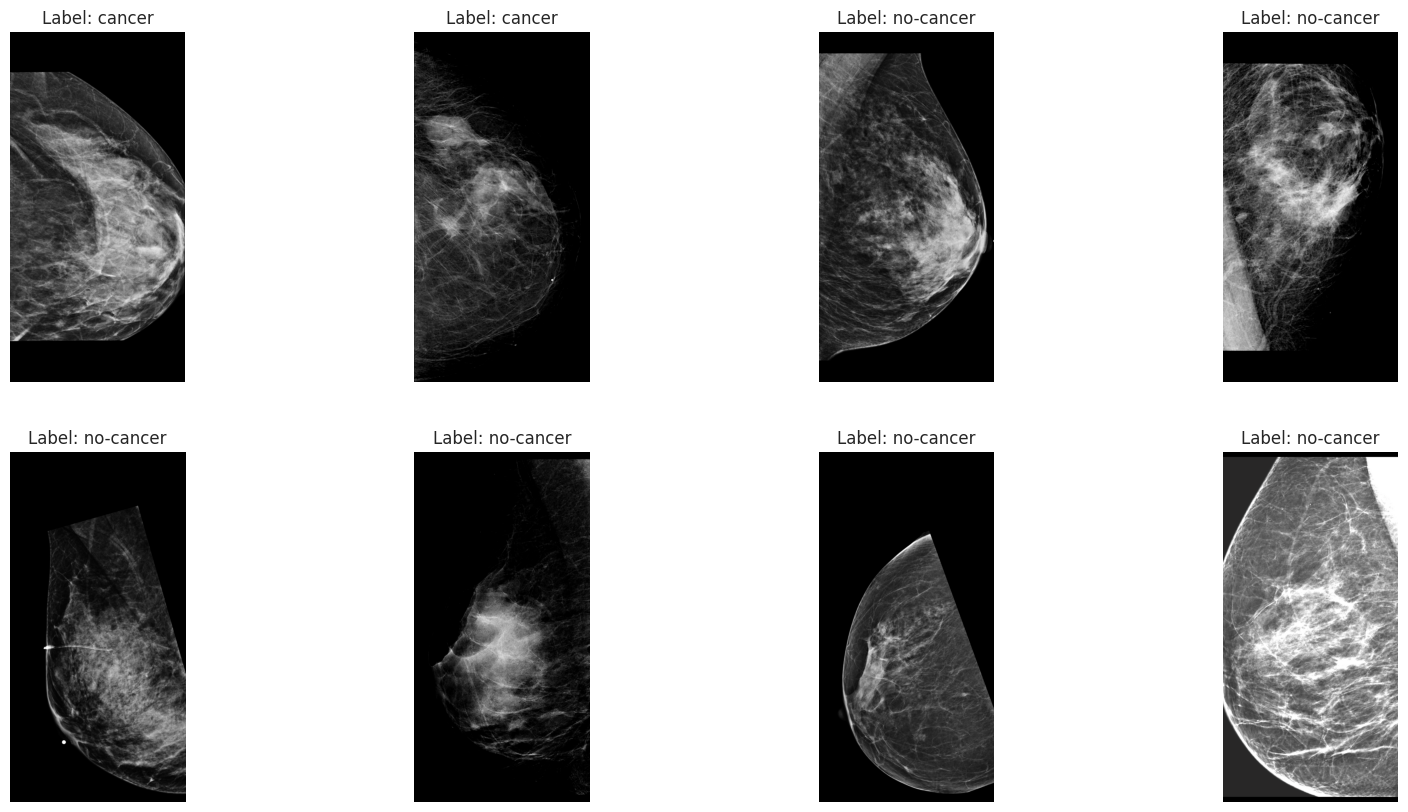

In [154]:
def unnormalize(img_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    img_tensor = img_tensor.cpu().clone()  # Clone the tensor to not affect the original one
    for t, m, s in zip(img_tensor, mean, std):
        t.mul_(s).add_(m)  # Un-normalize
    print(img_tensor.min())
    img_tensor = img_tensor.clamp(0, 1)  # Clamp values to the range [0, 1]
    
    return img_tensor.permute(1, 2, 0).numpy()

# Plot a few random preprocessed images from train_dataloader batch

# plot 2 x 4 (batch size = 8)
plt.figure(figsize=(20, 10))
labels = ['no-cancer', 'cancer']
for i, image in enumerate(images):
    image = unnormalize(image)
    plt.subplot(2, 4, i + 1)
    plt.imshow(image, cmap='bone')
    plt.axis('off')
    plt.title('Label: ' + labels[targets[i]])
    
plt.show()

In [22]:
def to_python_scalar(tensor):
    """
    Converts a PyTorch tensor to a Python scalar if applicable.
    """
    if torch.is_tensor(tensor):
        return tensor.item()
    else:
        return tensor

In [23]:
from sklearn.metrics import roc_auc_score

def calculate_metrics(outputs, targets, thresholds=np.linspace(0, 1, 101)):
    """
    Calculate accuracy, precision, recall, and F1 score of the model's predictions at different thresholds
    and find the best threshold.
    :param outputs: Model outputs.
    :param targets: True labels.
    :param thresholds: Range of thresholds to evaluate.
    :return: Best threshold and dictionary with accuracy, precision, recall, and F1 score for this threshold.
    """
    best_threshold = None
    best_metric = 0
    sigmoid_outputs = torch.sigmoid(outputs)

    for threshold in thresholds:
        predictions = (sigmoid_outputs > threshold).float()

        TP = ((predictions == 1) & (targets.unsqueeze(1) == 1)).float().sum()
        FP = ((predictions == 1) & (targets.unsqueeze(1) == 0)).float().sum()
        TN = ((predictions == 0) & (targets.unsqueeze(1) == 0)).float().sum()
        FN = ((predictions == 0) & (targets.unsqueeze(1) == 1)).float().sum()

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        F1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        # Update the best threshold based on the metric of choice
        if F1 > best_metric:
            best_metric = F1
            best_threshold = threshold

    # Calculate metrics for the best threshold
    best_predictions = (sigmoid_outputs > best_threshold).float()
    TP = ((best_predictions == 1) & (targets.unsqueeze(1) == 1)).float().sum()
    FP = ((best_predictions == 1) & (targets.unsqueeze(1) == 0)).float().sum()
    TN = ((best_predictions == 0) & (targets.unsqueeze(1) == 0)).float().sum()
    FN = ((best_predictions == 0) & (targets.unsqueeze(1) == 1)).float().sum()

    best_precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    best_recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    best_F1 = 2 * best_precision * best_recall / (best_precision + best_recall) if (best_precision + best_recall) > 0 else 0
    best_accuracy = (TP + TN) / (TP + FP + TN + FN)
    auc_roc = roc_auc_score(targets.cpu(), sigmoid_outputs.cpu())

    return best_threshold, {'accuracy': best_accuracy.item(), 'precision': best_precision.item(), 'recall': best_recall.item(), 'F1': best_F1.item(), 'AUC ROC': auc_roc}

In [25]:
def pfbeta_torch(labels, predictions, beta=1.0):
    """
    Compute the probabilistic F1 score (pFbeta) using PyTorch tensors.
    :param labels: Tensor of true labels (0 or 1).
    :param predictions: Tensor of model output probabilities.
    :param beta: Beta value for F-beta score. Default is 1.0 (F1 score).
    :return: Probabilistic F-beta score.
    """
    # Ensure labels and predictions are float tensors
    labels = labels.float()
    predictions = predictions.float()

    # Clamp predictions between 0 and 1
    predictions = torch.clamp(predictions, min=0, max=1)

    # Compute components of the probabilistic F-beta score
    beta_squared = beta ** 2
    ctp = torch.sum(predictions * labels)  # True positive contributions
    cfp = torch.sum(predictions * (1 - labels))  # False positive contributions
    y_true_count = labels.sum()  # Total number of true positives

    # Calculate precision and recall
    c_precision = ctp / (ctp + cfp) if (ctp + cfp) > 0 else torch.tensor(0.0)
    c_recall = ctp / y_true_count if y_true_count > 0 else torch.tensor(0.0)

    # Calculate pFbeta score
    if c_precision > 0 and c_recall > 0:
        pfbeta_score = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
    else:
        pfbeta_score = torch.tensor(0.0)

    return pfbeta_score.item()

In [26]:
def create_convnext_model(model_name, num_classes, in_chans=3, global_pool='avg', drop_rate=0.0, drop_path_rate=0.0, pretrained=False):
    """
    Create a ConvNext model.
    :param model_name: name of the model
    :param num_classes: number of classes
    :param in_chans: number of input channels
    :param global_pool: type of global pooling
    :param drop_rate: dropout rate
    :param drop_path_rate: drop path rate
    :param pretrained: whether to use pretrained weights
    :return: ConvNext model
    """
    convnext_model = create_model(
        model_name,
        pretrained=pretrained,
        num_classes=num_classes,
        in_chans=in_chans,
        global_pool=global_pool,
        drop_rate=drop_rate,
        drop_path_rate=drop_path_rate,
    )
    return convnext_model

In [27]:
import wandb
wandb.init(project='aai-521-final-project')

wandb: Currently logged in as: jeffreykthomas (jtdesigns). Use `wandb login --relogin` to force relogin


In [28]:
from tqdm import tqdm  
def train_and_evaluate(model, model_ema, train_loader, val_loader, optimizer, criterion, scheduler, device, epochs=1, grad_accum_steps = 4):
    """
    Train and evaluate the model for n epochs.
    :param model: Model to train and evaluate.
    :param train_loader: Training data loader.
    :param val_loader: Validation data loader.
    :param optimizer: Optimizer.
    :param criterion: Loss function.
    :param device: Device to use for training.
    :param epochs: Number of epochs to train.
    :return: Tuple of average training loss and average validation loss.
    """
    avg_train_loss = 0
    avg_val_loss = 0
    best_val_loss = float('inf')
        
    for epoch in range(epochs):
        model.train()
        sampler.set_epoch(epoch)
        train_loss = 0
        accum_iter = 0
        
        train_progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch + 1}/{epochs} Training', leave=False)
        for batch_idx, (data, target) in train_progress_bar:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.unsqueeze(1).float()) / grad_accum_steps
            loss.backward()
            
            if (accum_iter + 1) % grad_accum_steps == 0:
                optimizer.step()

            model_ema.update(model)                
            accum_iter += 1
            train_loss += loss.item() * grad_accum_steps
            train_progress_bar.set_postfix({'loss': loss.item()})
        
        avg_train_loss = train_loss / len(train_loader)
        
        # Evaluation loop
        model_ema.eval()
        val_loss = 0
        pfbeta = 0
        all_outputs = []
        all_targets = []
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model_ema.module(data)
                loss = criterion(output, target.unsqueeze(1).float())
                val_loss += loss.item()
                all_outputs.append(output)
                all_targets.append(target.unsqueeze(1))
                
                pfbeta += pfbeta_torch(target.unsqueeze(1), torch.sigmoid(output))
                
        all_outputs = torch.cat(all_outputs, dim=0)
        all_targets = torch.cat(all_targets, dim=0)
        best_threshold, val_metrics = calculate_metrics(all_outputs, all_targets.unsqueeze(1).float())
        avg_val_loss = val_loss / len(val_loader)
        avg_pfbeta = pfbeta / len(val_loader)
        
        if epoch == 0:
            wandb.watch(model, criterion, log='all', log_freq=10)
            
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model_ema.module.state_dict(), '/data/models/rsna/best_model_ema.pth')
            torch.save(conv_model.module.state_dict(), '/data/models/rsna/best_model.pth')

        
        wandb.log({'train_loss': avg_train_loss, 'val_loss': avg_val_loss, 'best_threshold': best_threshold, 'val_metrics': val_metrics, 'pfbeta': avg_pfbeta})
        print(f'\nEpoch: {epoch + 1}, Train Loss: {avg_train_loss:.6f}, Validation Loss: {avg_val_loss:.6f}, Best Threshold: {best_threshold}, Validation Metrics: {val_metrics}, pFbeta: {avg_pfbeta:.6f}')
        
        # Step the scheduler
        scheduler.step(epoch)

    return avg_train_loss, avg_val_loss

In [29]:
model_info = {
    'model_name': 'convnext_small.fb_in22k_ft_in1k_384',
    'pretrained': pretrained,
    'num_classes': 1,
    'in_chans': in_chans,
    'global_pool': global_pool,
    'drop_rate': drop_rate,
    'drop_path_rate': drop_path_rate,
}

In [30]:
from timm.utils import ModelEmaV2
conv_model = create_convnext_model(**model_info)
conv_model.to(device)

model_ema = ModelEmaV2(conv_model, decay=model_ema_decay)

In [31]:
import torch.nn as nn

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    conv_model = nn.DataParallel(conv_model)

Using 2 GPUs!


In [32]:
from cloned_pytorch_image_models.timm.loss import BinaryCrossEntropyPosSmoothOnly
from timm.optim import create_optimizer_v2
from timm.scheduler import create_scheduler_v2
optimizer = create_optimizer_v2(conv_model, opt='sgd', lr=lr, weight_decay=weight_decay, momentum=momentum)
criterion = BinaryCrossEntropyPosSmoothOnly(smoothing=smoothing, target_threshold=target_threshold, pos_weight=pos_weight)
scheduler, num_epochs = create_scheduler_v2(optimizer, sched=sched, num_epochs=num_epochs, decay_epochs=decay_epochs, cooldown_epochs=cooldown_epochs, warmup_epochs=warmup_epochs, min_lr=min_lr, warmup_lr=warmup_lr)

In [ ]:
train_loss, val_loss = train_and_evaluate(conv_model, model_ema, train_dataloader, val_dataloader, optimizer, criterion, scheduler, device, epochs=num_epochs, grad_accum_steps=grad_accum_steps)

Set epoch to 0 with sampler ratio = 0.25


Epoch 1/36 Training:   0%|          | 0/5724 [00:00<?, ?it/s]

STARTING COMPUTE EPOCH 0 SAMPLE INDEXS...
Current epoch sampler ratio: 0.25
5724 iters with 45792 samples


Epoch 1/36 Training:  14%|█▍        | 827/5724 [19:26<1:55:32,  1.42s/it, loss=0.294]

In [ ]:
conv_model.de

In [90]:
import gc
gc.collect()
torch.cuda.empty_cache()